In [28]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import yaml
from einops import rearrange

In [36]:
import mushroom.utils as utils
import mushroom.data.multiplex as multiplex

In [3]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1'
Path(project_dir).mkdir(parents=True, exist_ok=True)

In [7]:
fps = sorted(utils.listfiles(
    '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files',
    regex=r'-[Ss]mall.czi$'
))
fps

['/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A1-20x-Stitched-small.czi',
 '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A1-5x-Stitched-small.czi',
 '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A2-20x-Stitched-small.czi',
 '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A2-5x-Stitched-small.czi',
 '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A3-20x-Stitched-small.czi',
 '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A3-5x-Stitched-small.czi',
 '/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_

In [49]:
for fp in fps:
    sections = []
    case = re.sub(r'^.*/([^/]*)-[0-9]+x-[sS]titched.*$', r'\1', fp.replace('_', '-'))
    zoom = re.sub(r'^.*-([0-9]+)x-[sS]titched.*$', r'\1', fp.replace('_', '-'))
    output_dir = os.path.join(project_dir, 'lightsheet', f'{case}_{zoom}x', 'registered')
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    tf = tifffile.TiffFile(fp)
    res = tf.imagej_metadata['spacing']
    downsample_factor = tf.imagej_metadata['images'] / tf.imagej_metadata['slices']
    res *= downsample_factor
    res = 1 / res # switching to pix per micron instead of microns per pixel
    
    x = tifffile.imread(fp) # (z, c, h, w)
    
    # convert to uint8
    x = x.astype(np.float32)
    x /= x.max()
    x *= 255.
    x = x.astype(np.uint8)
    
    print(case, zoom, x.shape)
    
    for i, img in enumerate(x):
        sid = f'{case}-U{i}'
        save_fp = os.path.join(output_dir, f'{sid}_multiplex.ome.tiff')
        
        entry = {
            'sid': sid,
            'position': int((1 / res) * i),
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': save_fp
                }
            ]
        }
        
        sections.append(entry)
        
        multiplex.write_basic_ome_tiff(
            save_fp,
            x[i], [f'channel {c}' for c in range(x.shape[0])], pix_per_micron=res
        )
    
    data_map = {
        'target_sid': f'{case}-U0',
        'resolution': res,
        'sections': sections
    }
    yaml.safe_dump(data_map, open(os.path.join(output_dir, f'metadata.yaml'), 'w'))

HT427PI-A1 20 (679, 4, 337, 338)
HT427PI-A1 5 (206, 4, 338, 338)
HT427PI-A2 20 (836, 4, 345, 372)
HT427PI-A2 5 (239, 4, 343, 343)
HT427PI-A3 20 (887, 4, 346, 345)
HT427PI-A3 5 (186, 4, 343, 343)
HT427PI-A4 20 (874, 4, 348, 367)
HT427PI-A4 5 (207, 4, 343, 343)
HT442PI-A1 20 (735, 4, 342, 342)
HT442PI-A1 5 (264, 4, 454, 342)
HT442PI-A2 20 (651, 4, 341, 343)
HT442PI-A2 5 (269, 4, 453, 342)
HT442PI-A3 20 (682, 4, 341, 342)
HT442PI-A3 5 (285, 4, 342, 342)
HT442PI-A4 20 (1132, 4, 342, 342)
HT442PI-A4 5 (245, 4, 343, 342)
HT460P1-A1 20 (914, 4, 343, 341)
HT460P1-A1 5 (213, 4, 453, 342)
HT460P1-A2 20 (1212, 4, 346, 342)
HT460P1-A2 5 (486, 4, 333, 332)
HT460P1-A3 20 (944, 4, 341, 348)
HT460P1-A3 5 (255, 4, 338, 337)
HT461B1-A2 20 (1072, 4, 342, 340)
HT461B1-A2 5 (251, 4, 351, 221)
HT461B1-A3 20 (826, 4, 341, 341)
HT461B1-A3 5 (166, 4, 231, 231)
HT462P1-A2 20 (720, 4, 324, 372)
HT462P1-A2 5 (177, 4, 231, 231)
HT462P1-A3 20 (770, 4, 335, 344)
HT462P1-A3 5 (247, 4, 343, 231)
HT486B1-A1 20 (711, 4,

In [48]:
for fp in fps:
    case = re.sub(r'^.*/([^/]*)-[0-9]+x-[sS]titched.*$', r'\1', fp.replace('_', '-'))
    print(case)

HT427PI-A1
HT427PI-A1
HT427PI-A2
HT427PI-A2
HT427PI-A3
HT427PI-A3
HT427PI-A4
HT427PI-A4
HT442PI-A1
HT442PI-A1
HT442PI-A2
HT442PI-A2
HT442PI-A3
HT442PI-A3
HT442PI-A4
HT442PI-A4
HT460P1-A1
HT460P1-A1
HT460P1-A2
HT460P1-A2
HT460P1-A3
HT460P1-A3
HT461B1-A2
HT461B1-A2
HT461B1-A3
HT461B1-A3
HT462P1-A2
HT462P1-A2
HT462P1-A3
HT462P1-A3
HT486B1-A1
HT486B1-A1
HT491P1-A1
HT491P1-A1
HT491P1-A2
HT491P1-A2
HT491P1-A4
HT491P1-A4
HT495-A2
HT495-A2
HT495-A3
HT495-A3
HT495-A4
HT495-A4
HT497P1-A1
HT497P1-A1
HT497P1-A2
HT497P1-A2
HT497P1-A3
HT497P1-A3
HT502P1-A2
HT502P1-A2
HT502P1-A3
HT502P1-A3
HT514B1-A2
HT514B1-A2
HT514B1-A3
HT514B1-A3
HT517B1-A2
HT517B1-A2
HT530P1-A1
HT530P1-A1
HT530P1-A2
HT530P1-A2
HT530P1-A3
HT530P1-A3
HT530P1-A4
HT530P1-A4
HT535P1-A2
HT535P1-A2
HT535P1-A4
HT535P1-A4
HT541P1-A3
HT541P1-A3
HT545B1-A1
HT545B1-A1
HT545B1-A2
HT545B1-A2
HT545B1-A4
HT545B1-A4
HT547P1-A1
HT547P1-A1
HT547P1-A2
HT547P1-A2
HT547P1-A3
HT547P1-A3
HT553P1-A2
HT553P1-A2
HT553P1-A3
HT553P1-A3
HT553P1-A4
HT553P1-A4


In [34]:
output_dir

'/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/lightsheet/registered/HT427PI_20x'

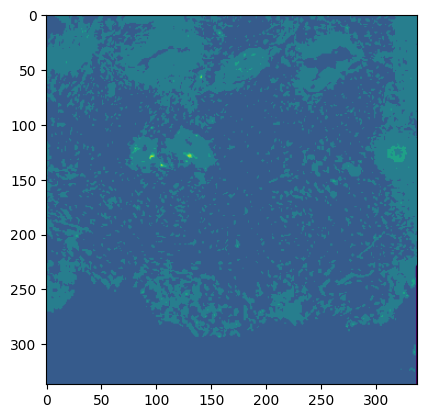

In [31]:
plt.imshow(x[100, 0])

In [25]:
x[0].shape

(4, 337, 338)

In [26]:
x.dtype

dtype('uint8')

In [22]:
x

array([[[[205, 208, 208, ..., 117, 118, 117],
         [205, 208, 208, ..., 209, 209, 207],
         [205, 208, 208, ..., 209, 209, 207],
         ...,
         [200, 203, 204, ..., 204, 195,  59],
         [200, 203, 203, ..., 204, 196,  59],
         [201, 203, 203, ..., 197, 188,  57]],

        [[205, 208, 209, ..., 116, 116, 116],
         [205, 208, 209, ..., 208, 207, 206],
         [206, 209, 209, ..., 207, 206, 205],
         ...,
         [208, 211, 212, ..., 209, 202,  62],
         [207, 211, 211, ..., 209, 201,  61],
         [207, 211, 211, ..., 201, 194,  59]],

        [[206, 209, 208, ..., 118, 118, 117],
         [205, 209, 209, ..., 209, 210, 207],
         [205, 209, 209, ..., 209, 209, 208],
         ...,
         [200, 203, 203, ..., 204, 196,  60],
         [200, 203, 203, ..., 204, 196,  60],
         [201, 203, 203, ..., 197, 189,  57]],

        [[206, 209, 211, ..., 117, 117, 117],
         [206, 210, 210, ..., 208, 208, 207],
         [207, 210, 210, ..., 20

In [8]:
x = tifffile.imread('/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A1-20x-Stitched-small.czi')
x.shape

(679, 4, 337, 338)

In [9]:
tf = tifffile.TiffFile('/diskmnt/Projects/Stemness_downloads/lightsheet/tiancheng_registration_and_visualization_files/HT427PI/visualization/HT427PI-A1-20x-Stitched-small.czi')
tf

<tifffile.TiffFile 'HT427PI-A1-20x-…itched-small.czi'>

In [11]:
tf.pages[0].description

'ImageJ=1.53t\nimages=2716\nchannels=4\nslices=679\nhyperstack=true\nmode=grayscale\nunit=micron\nspacing=1.962658281993883\nloop=false\nmin=0.0\nmax=65535.0'

In [13]:
len(tf.pages)

2716

In [14]:
tf.flags

{'imagej', 'uniform'}

In [15]:
tf.imagej_metadata

{'ImageJ': '1.53t',
 'images': 2716,
 'channels': 4,
 'slices': 679,
 'hyperstack': True,
 'mode': 'grayscale',
 'unit': 'micron',
 'spacing': 1.962658281993883,
 'loop': False,
 'min': 0.0,
 'max': 65535.0,
 'Info': ' BitsPerPixel = 16\n DimensionOrder = XYCZT\n IsInterleaved = false\n IsRGB = false\n LittleEndian = true\n PixelType = uint16\n Series 0 Name = 427PI-A1-20x #1\n SizeC = 4\n SizeT = 1\n SizeX = 1353\n SizeY = 1347\n SizeZ = 2715\nAppliance|Id = ShuttleAndFind:1\nDisplaySetting|Channel|BitCountRange = 16\nDisplaySetting|Channel|Color = #FFFFFFFF\nDisplaySetting|Channel|DyeMaxEmission = 415.00000000000006\nDisplaySetting|Channel|DyeName = Dye4\nDisplaySetting|Channel|High = 0.01277234783754002\nDisplaySetting|Channel|Id = 244396807812244896293519059335682219934\nDisplaySetting|Channel|IsSelected = false\nDisplaySetting|Channel|Low = 0.006494389371019752\nDisplaySetting|Channel|Name = Cam1-T4\nDisplaySetting|Channel|OriginalColor = #FFFFFFFF\nDisplaySetting|Channel|PixelTyp

In [16]:
# looks like downsample was by 4
2715 / 679

3.9985272459499264